# Package Imports #

In [1]:
# Import the necessary packages

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as mpgs
import glob
%matplotlib inline

# Helper Functions #

In [2]:
# Helper function to display images
# The input array should contain an even number of images

def display_images(imgarray, figsize=(18,32), titles=None):
    ncols = 2
    nrows = int(len(imgarray)/2)

    fig = plt.figure(figsize=figsize)
    gs = mpgs.GridSpec(nrows, ncols)
    gs.update(bottom=0.375)
    for i in range(len(imgarray)):
        sub = plt.subplot(gs[i])
        if titles is not None:
            sub.set_title(titles[i], size=17)
        sub.imshow(imgarray[i])

In [3]:
# Helper function to calibrate the camera

def calibrate_camera(chess_images):
       
    objpoints = []
    imgpoints = []
    
    # Initialize grid points to feed to objpoints
    objpoints_base = np.zeros((rows*cols, 3), np.float32)
    objpoints_base[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) 

    for img in chess_images:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (cols, rows))
        
        if(ret):
            # Append points and actual co-ordinates
            objpoints.append(objpoints_base)
            imgpoints.append(corners)
    
    print("\nCalibrating the camera using {} of {} chessboard images".format(len(imgpoints), len(chess_images)))
    
    # Calibrate the camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
       
    # Return the camera matrix and distortion coefficients
    return mtx, dist

In [4]:
# Helper function to undistort images

def undistort_images(dist_images, mtx, dist):
    
    # Use cv2 to undistort each image
    undistorted_images = np.array([cv2.undistort(img, mtx, dist) for img in dist_images])
    
    return undistorted_images

In [5]:
# Helper function to warp images with a perspective transform

def warp_images(src_images, M):
    
    # Calculate the image shape
    shape = src_images[0].shape[1::-1]
    
    # Use cv2 to apply the perspective transform on each image
    warped_images = np.array([cv2.warpPerspective(img, M, shape,
                                                  flags=cv2.INTER_LINEAR) for img in src_images])
    
    return warped_images 

# Initial Processing #
Code which uses the helper functions to calibrate the camera. Also demos undistortion.

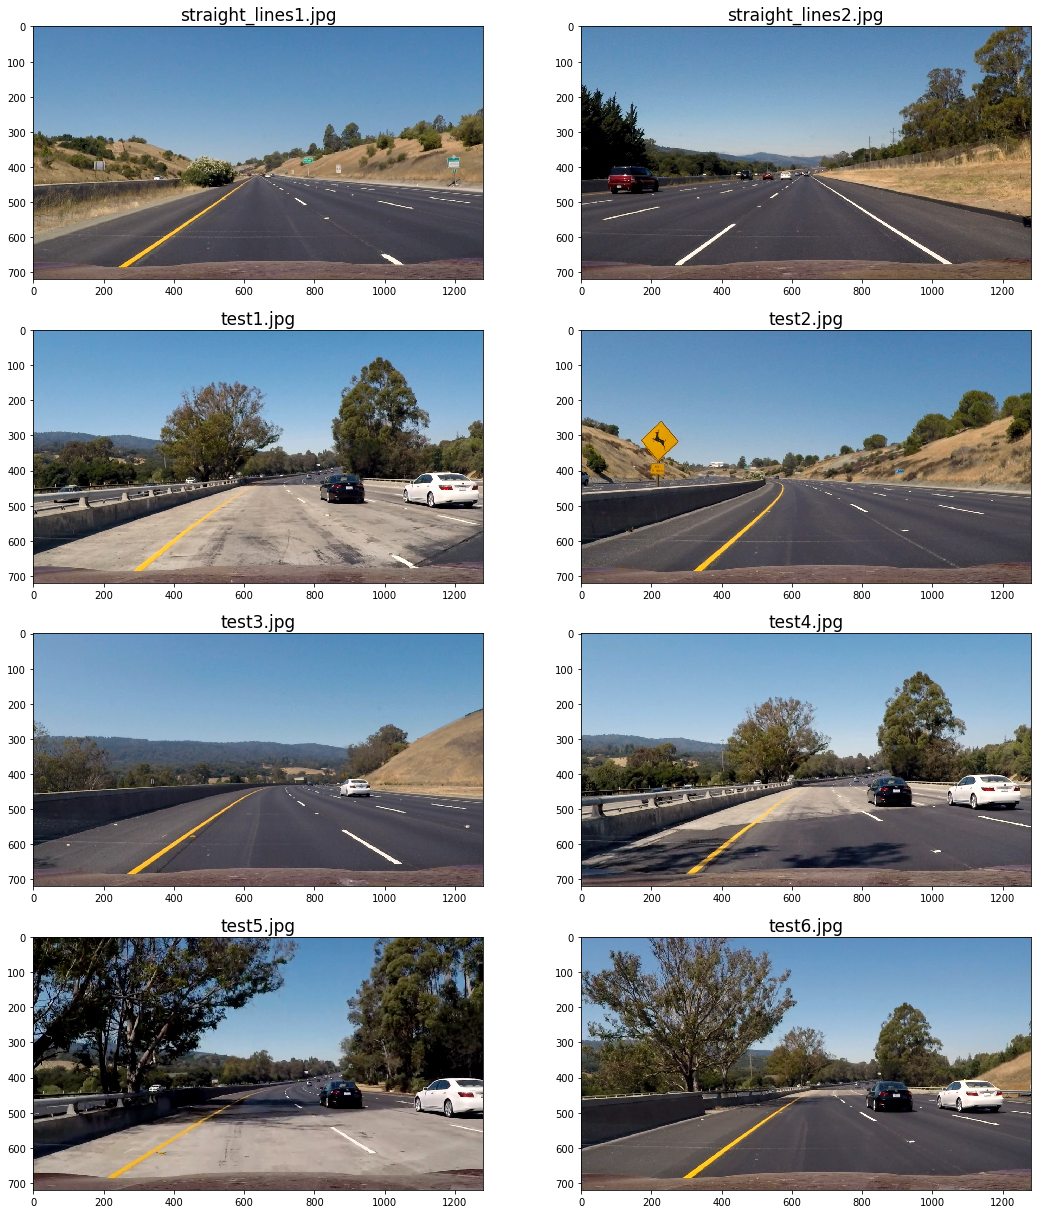

In [6]:
# Read in all the test images

filenames = glob.glob( "test_images\*.jpg")
test_images = np.array([mpimg.imread(name) for name in filenames])

# Display the first four test images
display_images(test_images, titles=[x.split("\\")[-1] for x in filenames])

## Camera Calibration ##

In [7]:
# Read the chessboard images
chess_filenames = glob.glob("camera_cal\calibration*.jpg")
chess_images =  np.array([mpimg.imread(name) for name in chess_filenames])
rows, cols = 6, 9

# Call the helper function to calibrate the camera
mtx, dist = calibrate_camera(chess_images)


Calibrating the camera using 17 of 20 chessboard images


In [8]:
# Call the helper function to undistort the test images
undist_images = undistort_images(chess_images, mtx, dist)

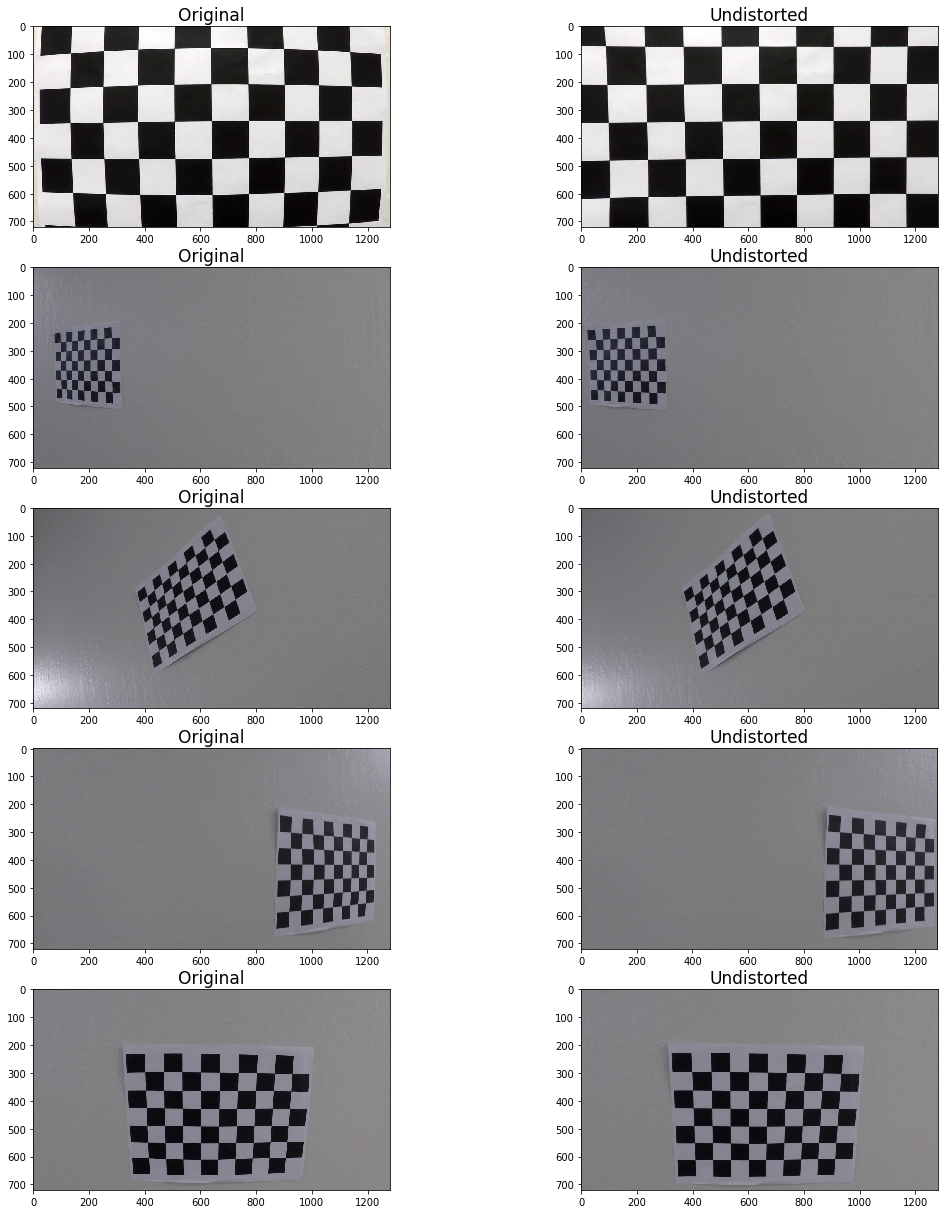

In [9]:
# Display 5 chess board images and their undistorted versions
display_images([ chess_images[i] if i%2==0 else undist_images[i-1] for i in range(0,10) ],
               titles=["Original", "Undistorted"]*5)

## Perspective Transform ##

In [10]:
# Pick an image for defining the perspective transform
source_img = test_images[0]

# Define the source and destination points for the perspective transform
srcTL = [584, 458]
srcTR = [701, 458]
srcBR = [1030, 668]
srcBL = [283, 668]

src = np.float32([srcTL, srcTR, srcBR, srcBL])
dst = np.float32([[375, 0], [900, 0], [900, 720], [375, 720]])
M = cv2.getPerspectiveTransform(src, dst)

warped_img = cv2.warpPerspective(source_img, M, source_img.shape[1::-1], flags=cv2.INTER_LINEAR)

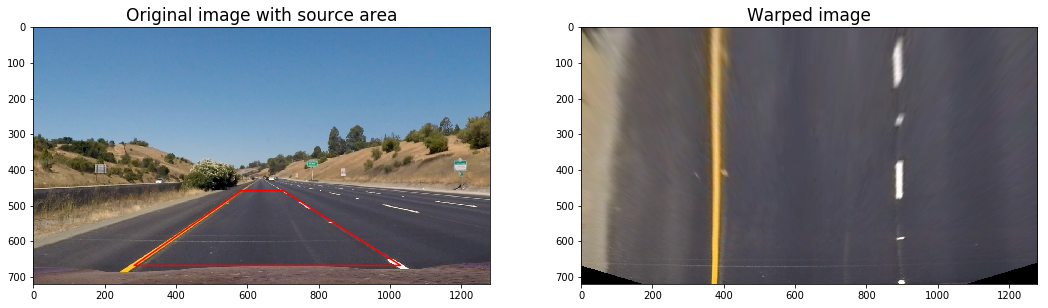

In [11]:
# Compare the original and warped image

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,32))
ax1.imshow(source_img)
ax1.plot([srcTL[0], srcTR[0], srcBR[0], srcBL[0], srcTL[0]],
         [srcTL[1], srcTR[1], srcBR[1], srcBL[1], srcTL[1]], color='red')
ax1.set_title("Original image with source area", size=17)
ax2.imshow(warped_img)
ax2.set_title("Warped image", size=17)

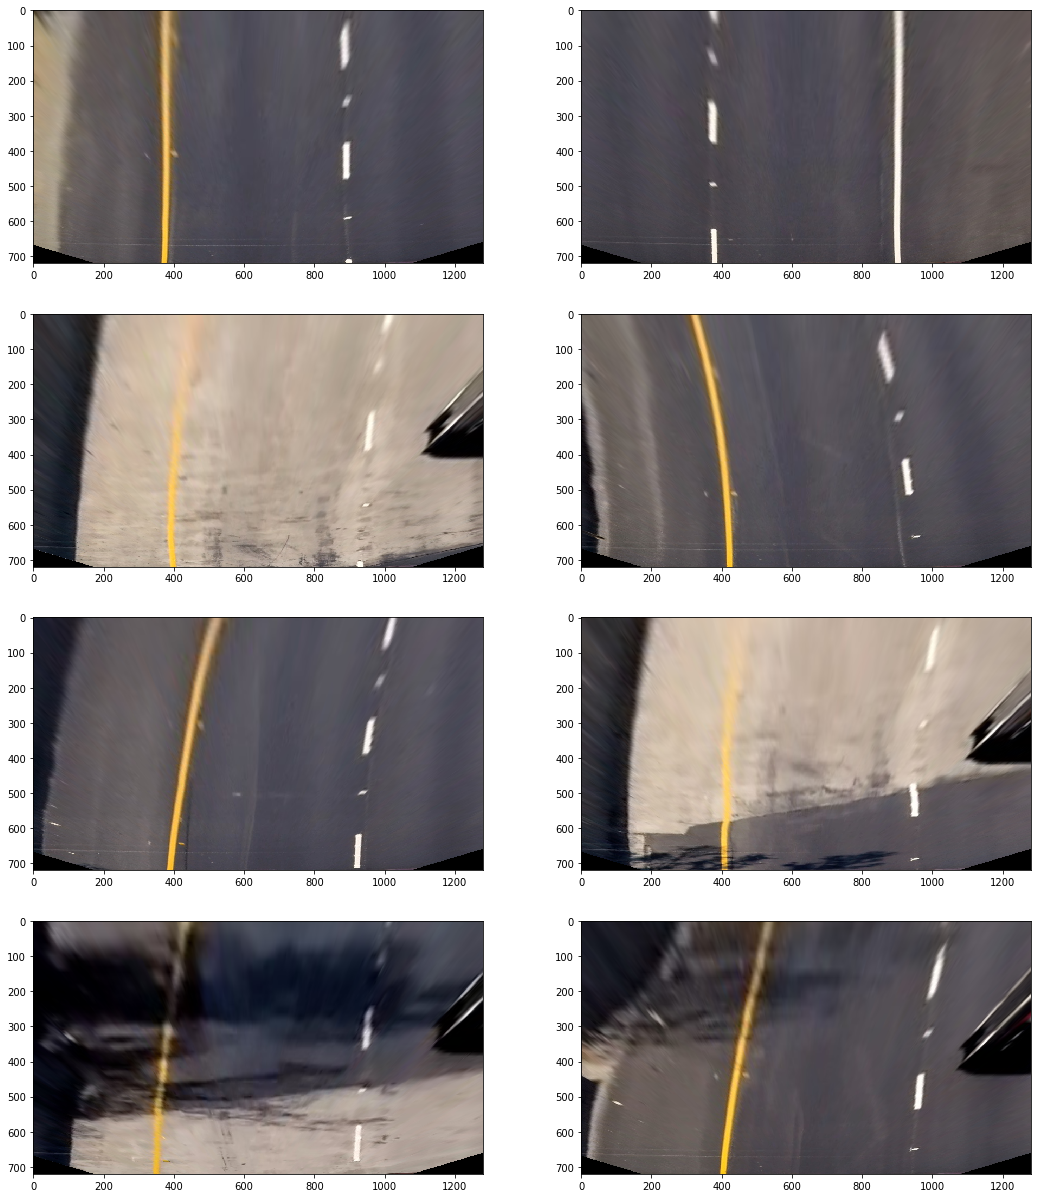

In [13]:
# Warp all test images and display them using the helper functions
display_images(warp_images(test_images, M))